## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

%config IPCompleter.greedy=True

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)
data['title'].head()

0      Miss
1    Master
2      Miss
3        Mr
4       Mrs
Name: title, dtype: object

In [6]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')


# cast numerical variables as floats
print(f'type of fare: {data["fare"].dtype}')
print(f'type of age: {data["age"].dtype}')


type of fare: float64
type of age: float64


In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
# data.head()
print(*data.columns, sep='\n')

pclass
survived
sex
age
sibsp
parch
fare
cabin
embarked
title


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var 
            for var in data.columns
            if data[var].dtypes != 'O' and var != target]

vars_cat = [var
           for var in data.columns
           if data[var].dtypes == 'O' and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [11]:
def find_na(X, cols):
    
    vars_with_na = list(filter(lambda col: X[col].isnull().any(), cols))
    
    return X[vars_with_na].isnull().sum().to_dict()

    
# first in numerical variables
find_na(data, vars_num)

{'age': 263, 'fare': 1}

In [12]:
# now in categorical variables
find_na(data, vars_cat)



{'cabin': 1014, 'embarked': 2}

### Determine cardinality of categorical variables

In [13]:
for var in vars_cat:
    print(f'{var} : {data[var].nunique()}')    

sex : 2
cabin : 181
embarked : 3
title : 5


### Determine the distribution of numerical variables

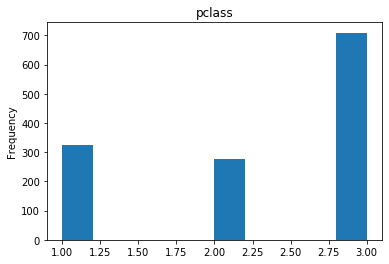

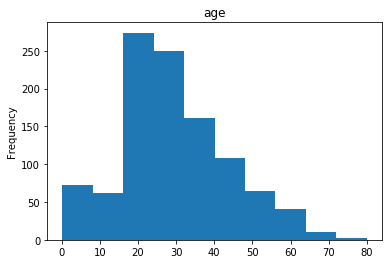

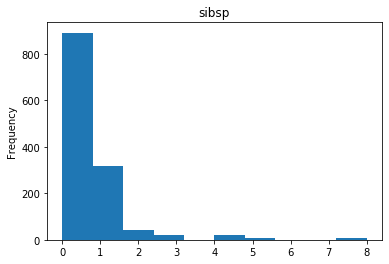

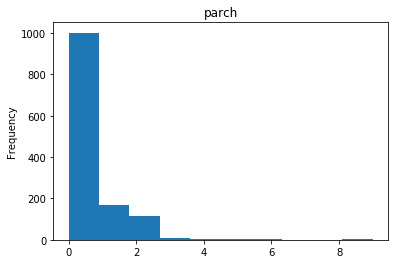

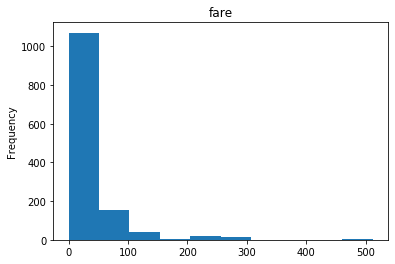

In [14]:
def print_distributions(X, col):

    X[col].plot(kind='hist')
    plt.title(col)
    plt.show()
    
for col in vars_num:
    print_distributions(data, col)
    

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape



((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
def get_first_cabin(row):
    try:
        return row[0]
    except:
        return np.nan
    
print(X_train['cabin'][~X_train['cabin'].isnull()].sample(5).to_list())
print(X_test['cabin'][~X_test['cabin'].isnull()].sample(5))    

X_train['cabin'] = X_train['cabin'].apply(get_first_cabin)
X_test['cabin'] = X_test['cabin'].apply(get_first_cabin)

print(X_train['cabin'][~X_train['cabin'].isnull()].sample(5).to_list())
print(X_test['cabin'][~X_test['cabin'].isnull()].sample(5))    


['E50', 'C47', 'C125', 'F33', 'D26']
55     B96
142    B82
312    C80
161    D11
124    B41
Name: cabin, dtype: object
['D', 'B', 'E', 'E', 'C']
194    C
49     B
215    D
55     B
295    C
Name: cabin, dtype: object


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [17]:
def get_mapper_median(X_train):
    mapper_median = X_train.agg('median').to_dict()
    joblib.dump(mapper_median, 'missing_numerical_mapper_median.pkl')

    return mapper_median

def create_missing_indicator(X, col):
    return np.where(X[col].isnull(), 1, 0)

def impute_na_numerical(X, col, mapper_median):
    return X[col].fillna(mapper_median[col])


vars_num_with_na = list({
    *[var for var in vars_num if X_train[var].isnull().any()],
    *[var for var in vars_num if X_test[var].isnull().any()]
})

get_mapper_median(X_train[vars_num_with_na])
mapper_median = joblib.load('missing_numerical_mapper_median.pkl')

print('========missing========')
print('========train========')
for col in X_train[vars_num_with_na].columns[X_train[vars_num_with_na].isnull().any()]:
    print(f'{col}: {X_train[col].isnull().sum()}')
print('========test========')
for col in X_test[vars_num_with_na].columns[X_test[vars_num_with_na].isnull().any()]:
    print(f'{col}: {X_test[col].isnull().sum()}')

print('')
print('############################')
print('')
# ============================================================================== #

# ======================= train ==========================
print('train')
print('===== before missing imputation ======')
print(X_train[vars_num_with_na].isnull().sum())

for col in vars_num_with_na:
    # train
    X_train[col + '_na'] = create_missing_indicator(X_train, col)
    X_train[col] = impute_na_numerical(X_train, col, mapper_median)

print('===== after missing imputation ======')
print('missing values:')
print(X_train[vars_num_with_na].isnull().sum())
print('missing indicator:')
print(X_train[[var + '_na' for var in vars_num_with_na]].sum())

# ======================= test ==========================
print('test')
print('===== before missing imputation ======')
print(X_test[vars_num_with_na].isnull().sum())

for col in vars_num_with_na:
    # train
    X_test[col + '_na'] = create_missing_indicator(X_test, col)
    X_test[col] = impute_na_numerical(X_test, col, mapper_median)

print('===== after missing imputation ======')
print('missing values:')
print(X_test[vars_num_with_na].isnull().sum())
print('missing indicator:')
print(X_test[[var + '_na' for var in vars_num_with_na]].sum())


========missing========
========train========
fare: 1
age: 206
========test========
age: 57

############################

train
===== before missing imputation ======
fare      1
age     206
dtype: int64
===== after missing imputation ======
missing values:
fare    0
age     0
dtype: int64
missing indicator:
fare_na      1
age_na     206
dtype: int64
test
===== before missing imputation ======
fare     0
age     57
dtype: int64
===== after missing imputation ======
missing values:
fare    0
age     0
dtype: int64
missing indicator:
fare_na     0
age_na     57
dtype: int64


### Replace Missing data in categorical variables with the string **Missing**

In [18]:

# ======================================================
# ======================================================
# ============================= Categorical Missing ================================ #
def impute_na_cat(X, col, replacement='Missing'):
    return X[col].fillna(replacement)

vars_cat_with_na = list({

    *[var for var in vars_cat if X_train[var].isnull().any()],
    *[var for var in vars_cat if X_train[var].isnull().any()]
})

print('========missing========')
print('========train========')
for col in vars_cat_with_na:
    print(f'{col}: {X_train[col].isnull().sum()}')
print('========test========')
for col in vars_cat_with_na:
    print(f'{col}: {X_test[col].isnull().sum()}')

for col in vars_cat:
    X_train[col] = impute_na_cat(X_train, col)
    X_test[col] = impute_na_cat(X_test, col)

print('========missing========')
print('========train========')
for col in vars_cat_with_na:
    print(f'{col}: {X_train[col].isnull().sum()}')
print('========test========')
for col in vars_cat_with_na:
    print(f'{col}: {X_test[col].isnull().sum()}')


========missing========
========train========
embarked: 2
cabin: 803
========test========
embarked: 0
cabin: 211
========missing========
========train========
embarked: 0
cabin: 0
========test========
embarked: 0
cabin: 0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [19]:
for var in vars_cat:
    print(f'=========={var}=========')
    print(X_train[var].value_counts(normalize=True).round(3).to_dict())
    print(f'=======================')

==========sex=========
{'male': 0.633, 'female': 0.367}
==========cabin=========
{'Missing': 0.767, 'C': 0.074, 'B': 0.05, 'D': 0.034, 'E': 0.034, 'A': 0.018, 'F': 0.017, 'G': 0.004, 'T': 0.001}
==========embarked=========
{'S': 0.71, 'C': 0.196, 'Q': 0.093, 'Missing': 0.002}
==========title=========
{'Mr': 0.569, 'Miss': 0.201, 'Mrs': 0.16, 'Master': 0.045, 'Other': 0.026}


In [20]:

def get_frequent_labels(X, col, th=0.05):
    labels = X[col].value_counts(normalize=True)
    frequent_labels = labels[labels > th].index.to_list()
    return frequent_labels

def replace_rare_labels(X, col, frequent_labels, rare_label='Rare'):
    return np.where(X[col].isin(frequent_labels[col]), X[col], rare_label)


joblib.dump(
    {col: get_frequent_labels(X_train, col) for col in vars_cat},
    'frequent_labels.pkl'
)
frequent_labels = joblib.load('frequent_labels.pkl')
import json
print('train')
for var in vars_cat:
    print(f'=========={var}=========')
    print(f'==========before=========')
    print(json.dumps(X_train[var].value_counts(normalize=True).round(3).to_dict(), indent=-1))
    print(f'=======================')

    X_train[var] = replace_rare_labels(X_train, var, frequent_labels, rare_label='Rare')

    print(f'==========after=========')
    print(json.dumps(X_train[var].value_counts(normalize=True).round(3).to_dict(), indent=-1))
    print(f'=======================')


print('test')
for var in vars_cat:
    print(f'=========={var}=========')
    print(f'==========before=========')
    print(json.dumps(X_test[var].value_counts(normalize=True).round(3).to_dict(), indent=-1))
    print(f'=======================')

    X_test[var] = replace_rare_labels(X_test, var, frequent_labels, rare_label='Rare')

    print(f'==========after=========')
    print(json.dumps(X_test[var].value_counts(normalize=True).round(3).to_dict(), indent=-1))
    print(f'=======================')



train
==========sex=========
==========before=========
{
"male": 0.633,
"female": 0.367
}
==========after=========
{
"male": 0.633,
"female": 0.367
}
==========cabin=========
==========before=========
{
"Missing": 0.767,
"C": 0.074,
"B": 0.05,
"D": 0.034,
"E": 0.034,
"A": 0.018,
"F": 0.017,
"G": 0.004,
"T": 0.001
}
==========after=========
{
"Missing": 0.767,
"Rare": 0.159,
"C": 0.074
}
==========embarked=========
==========before=========
{
"S": 0.71,
"C": 0.196,
"Q": 0.093,
"Missing": 0.002
}
==========after=========
{
"S": 0.71,
"C": 0.196,
"Q": 0.093,
"Rare": 0.002
}
==========title=========
==========before=========
{
"Mr": 0.569,
"Miss": 0.201,
"Mrs": 0.16,
"Master": 0.045,
"Other": 0.026
}
==========after=========
{
"Mr": 0.569,
"Miss": 0.201,
"Mrs": 0.16,
"Rare": 0.071
}
test
==========sex=========
==========before=========
{
"male": 0.687,
"female": 0.313
}
==========after=========
{
"male": 0.687,
"female": 0.313
}
==========cabin=========
==========before=========
{
"Missing

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [21]:
# ==========================================================================
#  ========== Perform One Hot encoding =================
# =========================================================================
import json

from feature_engine.categorical_encoders import OneHotCategoricalEncoder
# X=X_train.select_dtypes(include=[object])

for var in vars_cat:
    print(var)
    print(json.dumps(X_train[var].value_counts(normalize=True).round(3).to_dict(), indent=4))

encoder = OneHotCategoricalEncoder(
    top_categories=None,
    variables=vars_cat,
    drop_last=True,
)

encoder=encoder.fit(X_train)
encoder.encoder_dict_
# train
X_train = encoder.transform(X_train)
# test
X_test = encoder.transform(X_test)

print('train')
print(X_train.columns.to_list())
print('===========================0')
print('test')
print(X_test.columns.to_list())



sex
{
    "male": 0.633,
    "female": 0.367
}
cabin
{
    "Missing": 0.767,
    "Rare": 0.159,
    "C": 0.074
}
embarked
{
    "S": 0.71,
    "C": 0.196,
    "Q": 0.093,
    "Rare": 0.002
}
title
{
    "Mr": 0.569,
    "Miss": 0.201,
    "Mrs": 0.16,
    "Rare": 0.071
}
train
['pclass', 'age', 'sibsp', 'parch', 'fare', 'fare_na', 'age_na', 'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_S', 'embarked_C', 'embarked_Q', 'title_Mr', 'title_Miss', 'title_Mrs']
===========================0
test
['pclass', 'age', 'sibsp', 'parch', 'fare', 'fare_na', 'age_na', 'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_S', 'embarked_C', 'embarked_Q', 'title_Mr', 'title_Miss', 'title_Mrs']


### Scale the variables

- Use the standard scaler from Scikit-learn

In [23]:

# ==========================================================================
#  ========== Perform One Hot encoding =================
# =========================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)

scaler = scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# train
print('train')
print(X_train.mean().mean())
print(X_train.std().mean())
print('============')

# test
print('test')
print(X_test.mean().mean())
print(X_test.std().mean())
print('============')


train
-2.2479332149298308e-17
1.00047789727937
test
-0.0044161228738798484
0.9327353937183537


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [24]:
C = 1/0.0005
model = LogisticRegression(C=C, random_state=0)
model = model.fit(X_train, y_train)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**